In [1]:
import pathlib
import pickle
import itertools

import geopandas as gpd
import pandas as pd
import shapely

import networkx as nx
import matplotlib.pyplot as plt

## Visualizing and Routing with the EURIS Inland Waterway Network

This notebook demonstrates how to load and analyze the European inland waterway network using the **EURIS graph** dataset within the OpenTNSim ecosystem. The goal is to compute a route between two inland ports—**Maasvlakte** and **Duisburg**—and visualize navigational attributes such as available draught.

# Load Graph Data
We begin by loading a pickled `networkx` graph that models the EURIS inland fairway system. Nodes and edges contain metadata about physical waterway 

In [2]:
data_dir = pathlib.Path('~/data/euris').expanduser()
version = 'v0.1.0'

In [3]:
with ((data_dir / version) / 'export-graph-v0.1.0.pickle').open('rb') as f:
    graph = pickle.load(f)

# Visualize subgraphs
Using geopandas, all nodes are plotted and colored by subgraph identifiers, giving insight into distinct waterway segments or regions.

In [4]:
nodes_gdf = gpd.GeoDataFrame(graph.nodes.values(), index=graph.nodes.keys())

<Axes: >

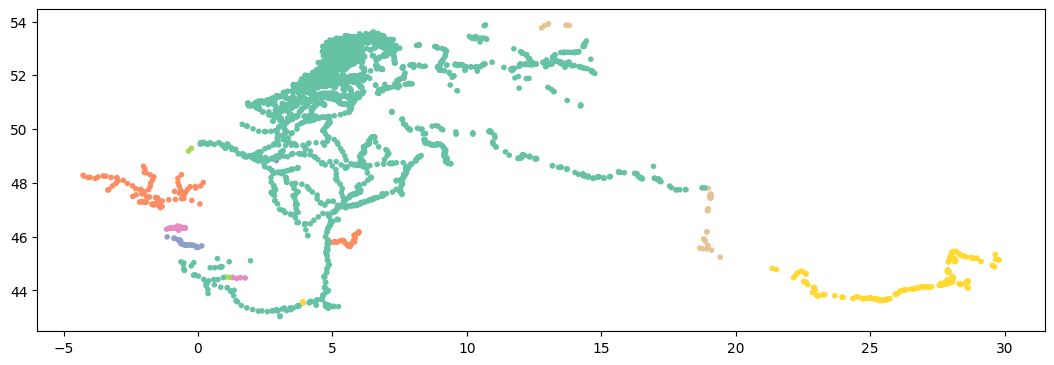

In [5]:
# plot all the nodes from the network, colored by subgraphs of the network
nodes_gdf.plot(marker='.', column='subgraph', figsize=(13, 8), cmap='Set2')

# Define Origin & Destination
Coordinates for Maasvlakte and Duisburg are specified, and the nearest network nodes are identified using a spatial index.

In [6]:
maasvlakte = shapely.Point(4.061031, 51.948096)
duisburg = shapely.Point(6.750669, 51.455185)

In [7]:
distances, idx = nodes_gdf.sindex.nearest(maasvlakte)
maasvlakte_node = nodes_gdf.iloc[idx[0]]
distances, idx = nodes_gdf.sindex.nearest(duisburg)
duisburg_node = nodes_gdf.iloc[idx[0]]

# Compute Shortest Path
We use Dijkstra’s algorithm to determine the shortest navigable route between the selected nodes, weighted by edge length (length_m).

In [8]:
route = nx.shortest_path(graph, maasvlakte_node.name, duisburg_node.name, weight='length_m')

# Construct Route as GeoDataFrame
Pairwise edges from the route are extracted and converted into a GeoDataFrame for geographic visualization and analysis.

In [9]:
edges = []
for e in itertools.pairwise(route):
    edge = graph.edges[e]
    edges.append(edge)
route_gdf = gpd.GeoDataFrame(edges)

In [10]:
route_gdf.head(n=2).T

,0,1
name,Europahaven,Toeloop naar Europahaven
name_cb,None,None
cntrycode,NL,NL
cntrycode_cb,None,None
fw_code,01156,01156
fw_code_cb,None,None
seq_nr,00036,00000
seq_nr_cb,None,None
code_cb,None,None
ww_name,Europahaven,Europahaven


# Analyze Maximum Draught
Route segments are filtered and colored based on available draught (mdraughtcm), which is a critical constraint for vessel navigation.

In [11]:
# Not much information here.... 
route_gdf['mdraughtcm'].dropna().unique()

array([440., 280., 300.])

# Final Plot of Route and Attributes
We overlay the route, origin/destination nodes, and color segments by draught to visualize navigational feasibility.

(51.44350654, 51.96206963)

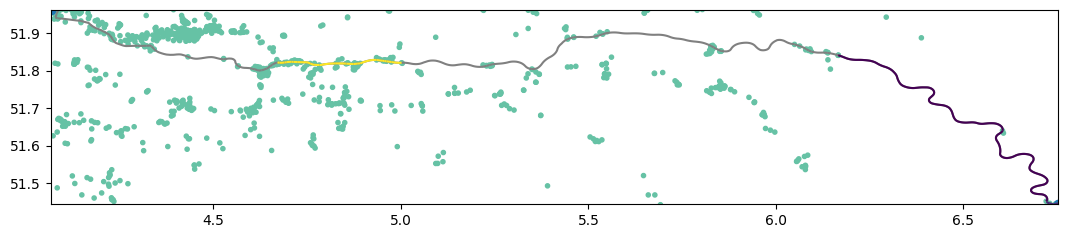

In [12]:

fig, ax = plt.subplots(figsize=(13, 8))
nodes_gdf.plot(marker='.', column='subgraph', cmap='Set2', ax=ax)
route_gdf.plot(ax=ax, color='grey')
# plot colors where maximum draught is available (small subset)
route_gdf.plot(column='mdraughtcm', ax=ax)
gpd.GeoDataFrame([duisburg_node, maasvlakte_node]).plot(ax=ax)
min_x, min_y, max_x, max_y = route_gdf.total_bounds
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
